<br>
<img src="https://cdn.slidesharecdn.com/ss_thumbnails/netflixprize-170320014819-thumbnail-4.jpg?cb=1489978383" width='25%'>
<h1 align='center'> Netflix Prize Challenge </h1>
<h2 align='center'> <font color='#FC7307'> Movie Recommendation </font> </h2>
<h3 align='center'>  Wenyi Hu </h3>
<br>

## Problem Description
Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.

Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.

The challenge's goal is to develop a system that could beat the RMSE accuracy of 0.9514 from their in-house developed recommendation system (the Cinematch) by 10%. In 2009, the prize was awarded to team ”BellKor’s Pragmatic Chaos” with RMSE of 0.8567 or 10.06% improvement. 

## About the Project
1. Predict the rating that a user would give to a movie that he/she has not yet rated (Rating from 1 to 5).
2. Minimize the difference between predicted and actual rating (RMSE)

## <a name='#toc'></a> Table of Contents

1. [Import Libraries](#1.-Import-Libraries)
2. [Load Data](#2.-Load-Data)
3. [EDA](#3.-EDA)
4. [Data Preprocessing](#4.-Data-Preprocessing)
5. [Machine Learning](#5.-Machine-Learning)
6. [Deep Learning](#6.-Deep-Learning)
    1. [Train/Test Preparation](#6.1-Train/Test-Preparation)
    2. [Build Model Architecture](#6.2-Build-Keras-Model-Architecture)
    3. [Train Model](#6.3-Train-Model)
    4. [Model Evaluation](#6.4-Model-Evaluation)

# 1. Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import random

# for ploting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True) 

# from skikit-surprise import functions:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

# for data preprocessing
from sklearn.preprocessing import LabelEncoder

# import model validation method
from sklearn.model_selection import train_test_split

# imports for deep learning
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Concatenate, Dense, Dropout, Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

# 2. Load Data

In [2]:
%%time

# DataFrame to store all imported data
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')

files = ['combined_data_1.txt',
         'combined_data_2.txt',
         'combined_data_3.txt', 
         'combined_data_4.txt'
        ]

# Combine all data files into a csv file
for file in files:
    print("Opening file: {}".format(file))
    with open(file) as f:
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                movie_id = line.replace(':', '')
            else:
                data.write(movie_id + ',' + line)
                data.write('\n')
data.close()

Opening file: combined_data_1.txt
Opening file: combined_data_2.txt
Opening file: combined_data_3.txt
Opening file: combined_data_4.txt
CPU times: total: 1min 39s
Wall time: 1min 41s


In [3]:
# Read all data into a pd dataframe
data = pd.read_csv('data.csv', names=['movie_id', 'user_id','rating','date'])

# Convert date to datetime type
data['date'] = pd.to_datetime(data['date'])

print(data.nunique())

movie_id     17770
user_id     480189
rating           5
date          2182
dtype: int64


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   movie_id  int64         
 1   user_id   int64         
 2   rating    int64         
 3   date      datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.0 GB


In [5]:
data.isnull().sum()

movie_id    0
user_id     0
rating      0
date        0
dtype: int64

In [6]:
data.describe()

,movie_id,user_id,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


# 3. EDA

In [7]:
df = data
df.head()

,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


**Profiling report**: The dataset is too large that the computer cannot loading the report

In [8]:
##Uncomment the code to run and load the report.

#from pandas_profiling import ProfileReport

#profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

#profile.to_widgets()

**Define a function to make y-axis more readable (by changing the unit)**

In [9]:
def y_label(num, units = 'M'):
    units = units.lower()
    num = float(num) 
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) + " B"

**Distribution of ratings**:
The most rating is 4, and the least rating is 1. 

D:\Wangke\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\MartinGuo\AppData\Local\Temp\ipykernel_19772\1944939720.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y_label(item, 'M') for item in ax.get_yticks()])


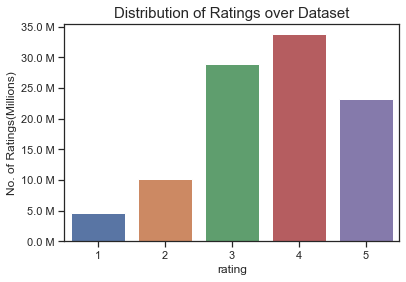

In [10]:
fig, ax = plt.subplots()
plt.title('Distribution of Ratings over Dataset', fontsize=15)
sns.countplot(df.rating)
ax.set_yticklabels([y_label(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')
plt.show()

**Number of ratings trend**: The number of ratings per month gradually increased since 1999. The number of ratings in Jan 2004 was twice as that in 2000. After 1 year (in Jan 2005), the number of ratings was 2.5 times more.

In [11]:
data['date'].max()

Timestamp('2005-12-31 00:00:00')

In [12]:
data['date'].min()

Timestamp('1999-11-11 00:00:00')

C:\Users\MartinGuo\AppData\Local\Temp\ipykernel_19772\2956781675.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y_label(item, 'M') for item in ax.get_yticks()])


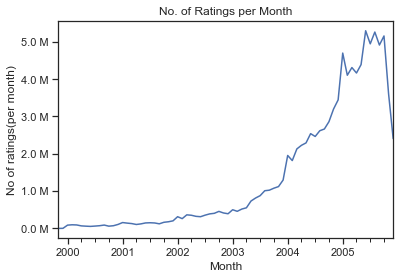

In [13]:
ax = df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No. of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([y_label(item, 'M') for item in ax.get_yticks()])
plt.show()

**Number of ratings on each day of the week**: Tuesday has the most ratings, and Saturday has the least ratings.The distribution of ratings in each day is similar.

In [14]:
df['day_of_week'] = df.date.dt.weekday

D:\Wangke\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\MartinGuo\AppData\Local\Temp\ipykernel_19772\138514957.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y_label(item, 'M') for item in ax.get_yticks()])


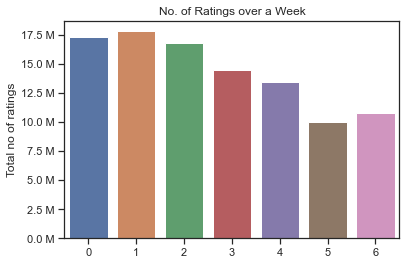

In [15]:
fig, ax = plt.subplots()
sns.countplot(df['day_of_week'])
plt.title('No. of Ratings over a Week')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([y_label(item, 'M') for item in ax.get_yticks()])
plt.show()

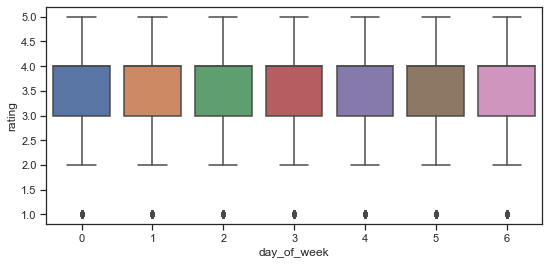

In [16]:
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=df)
plt.show()

**The number of ratings given by a user**: Most of users gave a small number of ratings. Only a few users (like the film critics）gave a large number of ratings.

In [17]:
no_of_rated_movies_per_user = df.groupby('user_id')['rating'].count().sort_values(ascending=False)

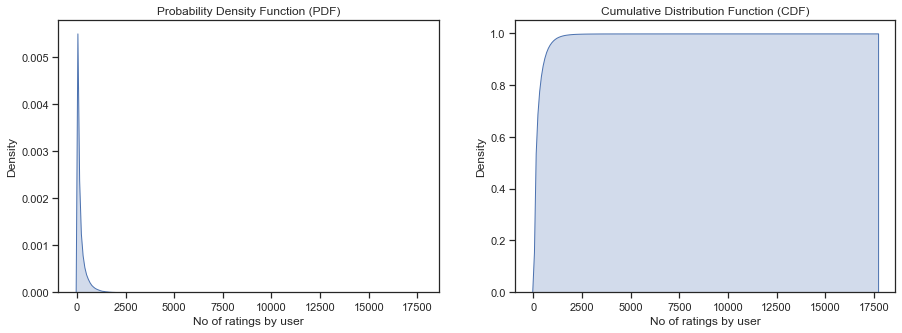

In [18]:
fig = plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True)
plt.xlabel('No of ratings by user')
plt.title("Probability Density Function (PDF)")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True)
plt.xlabel('No of ratings by user')
plt.title('Cumulative Distribution Function (CDF)');

**Ratings of a movie given by users**: Most of movies were given small number of ratings, only a small number of movies (like the really popular ones) were given lots of ratings.

In [19]:
no_of_ratings_per_movie = df.groupby('movie_id')['rating'].count().sort_values(ascending=False)

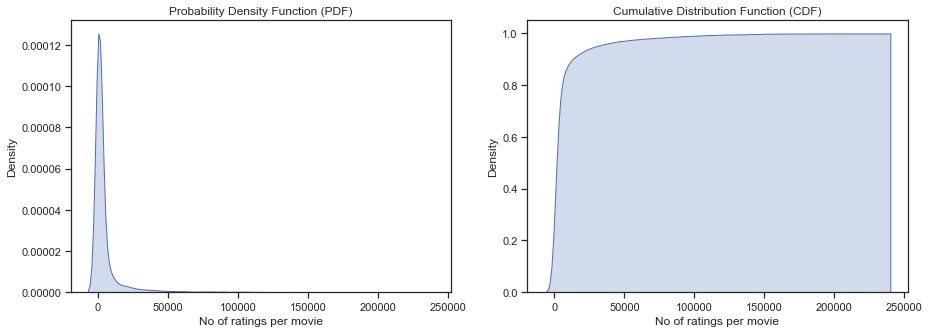

In [20]:
fig = plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_ratings_per_movie, shade=True)
plt.xlabel('No of ratings per movie')
plt.title('Probability Density Function (PDF)')

ax2 = plt.subplot(122)
sns.kdeplot(no_of_ratings_per_movie, shade=True, cumulative=True)
plt.xlabel('No of ratings per movie')
plt.title('Cumulative Distribution Function (CDF)');

# 4. Data Preprocessing

A smaller dataset (users gave the most rates on most movies) is chosen for the project, with 1000 top rated movies and 10,000 top users. The 12% of the ratings are retained from the whole records.

In [21]:
df = pd.DataFrame()

group = data.groupby('user_id')['rating'].count().rename('user_rating_cnt')
top_users = group.sort_values(ascending=False)[:10000]

group = data.groupby('movie_id')['rating'].count().rename('movie_rating_cnt')
top_movies = group.sort_values(ascending=False)[:1000]

df = data.join(top_users, how='inner', on='user_id')
df = df.join(top_movies, how='inner', on='movie_id')

df.reset_index(drop=True, inplace=True)

Re-name the users and movies for uniform name from 0 to 10000 and 1000 respectively

In [22]:
enc = LabelEncoder()
df['user_id'] = enc.fit_transform(df['user_id'].values)
df['movie_id'] = enc.fit_transform(df['movie_id'].values)

df.to_csv('top_rating_df.csv', header = True, index = False)

In [23]:
n_movies = df['movie_id'].nunique()
n_users = df['user_id'].nunique()
print('The number of movies is:',n_movies)
print('The number of users is',n_users)
print('The number of records (rows) of data processed is',len(df))

The number of movies is: 1000
The number of users is 10000
The number of records (rows) of data processed is 6264018


Correlation

In [24]:
df.corr().style.background_gradient(cmap='coolwarm')

,movie_id,user_id,rating,day_of_week,user_rating_cnt,movie_rating_cnt
movie_id,1.000000,0.000017,0.005035,0.001195,-0.000355,0.017793
user_id,0.000017,1.000000,0.003720,0.001492,-0.005607,0.000270
rating,0.005035,0.003720,1.000000,-0.000265,-0.030399,0.085126
day_of_week,0.001195,0.001492,-0.000265,1.000000,0.002156,-0.004308
user_rating_cnt,-0.000355,-0.005607,-0.030399,0.002156,1.000000,-0.030387
movie_rating_cnt,0.017793,0.000270,0.085126,-0.004308,-0.030387,1.000000


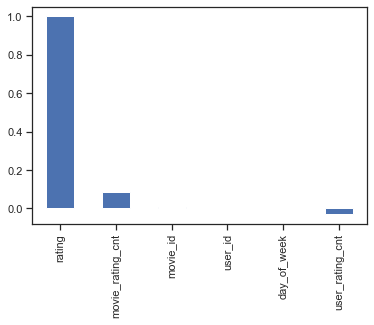

In [25]:
df.corr().loc[:,'rating'].sort_values(ascending = False).plot(kind='bar');

# 5. Machine Learning

## SVD in GridSearchCV
1. Prepare train/test sets
    - A is used for parameter tuning using grid search. 
    - B is used for unbiased estimation.
2. Build a GridSearchCV with a list of parameters
    - Single Value Decomposition(SVD) algorithm is used for matrix factorization.
    - Cross validation with 3 folds is used to train the model.
    - Root Mean Squared Error(RMSE) is uesed to evaluate the model.
3. Run GridSearchCV to find the best estimator
    - Fit the model on the training set (A).
4. Apply the best estimator to predict the rating
    - Apply the best estimator to the the RMSE score on testing sets(A and B).

In [26]:
%%time
# Choose user, movie, and rating columns for modelling.
dataframe = df[['user_id','movie_id','rating']]

# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1,5))

# Load the full dataset from a pandas dataframe.
data = Dataset.load_from_df(dataframe, reader)
raw_ratings = data.raw_ratings

# shuffle ratings
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(0.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

# Select your best algo with grid search.
print("Grid Search...")
param_grid = {'n_factors': [50, 100, 200],
              'n_epochs': [5, 10, 20], 
              'lr_all': [0.001, 0.002, 0.005],
              'reg_all':[0.01, 0.02, 0.05],
              'random_state':[42, 100]
             }
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
grid_search.fit(data)

# Best RMSE score
print('Best RMSE score:',grid_search.best_score["rmse"])

# Combination of parameters that gave the best RMSE score
print('Best parameters:', grid_search.best_params["rmse"])

# Get the best estimator
algo = grid_search.best_estimator["rmse"]

# Retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on A,", end="   ")
accuracy.rmse(predictions)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print("Unbiased accuracy on B,", end=" ")
accuracy.rmse(predictions)

Grid Search...
Best RMSE score: 0.7884358160198635
Best parameters: {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02, 'random_state': 42}
Biased accuracy on A,   RMSE: 0.7050
Unbiased accuracy on B, RMSE: 0.7725
CPU times: total: 4h 40min 55s
Wall time: 4h 40min 55s


0.7724601297178781

In [28]:
# Model prediction with input user_id, movie_id, and rating(optional)
algo.predict(1488844,20)

# 'uid' is user_id, 'iid' is item_id, 'r_ui' is real rating, 'est' is predicted rating

Prediction(uid=1488844, iid=20, r_ui=None, est=3.2609337106421483, details={'was_impossible': False})

# 6. Deep Learning

## 6.1 Train/Test Preparation
Select only 'user' and 'movie' to do deep learning, and convert X, y to np.array

In [29]:
X = df[['user_id', 'movie_id']].values
y = df['rating'].values

Train/Test Sets Preparation

In [30]:
# Split train and test data (for test model performance at last)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1)

# Split train and validation data (to monitor model performance in training)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1)

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

## 6.2 Build Keras Model Architecture

In [31]:
# Set the embedding dimension of Matrix factorization
e_dimension = 200 # was 50

# Build user and movie embedding matrix
user = Input(shape=(1,))
u = Embedding(n_users, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(user) # embedding was 1e-6
u = Reshape((e_dimension,))(u)

movie = Input(shape=(1,))
m = Embedding(n_movies, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(movie)  # embedding was 1e-6
m = Reshape((e_dimension,))(m)

x = Dot(axes=1)([u, m])

# concat user, movie along with dot
x = Concatenate()([u, m, x])

x = Dropout(0.2)(x)

# Build last deep learning layers 
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', 
              optimizer=Adam(lr=0.001),  ## 0.003
              metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )

# Set up for early stop if the validation loss stop improving for more than 1 epoch
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=1,
                                                ),
                  # Saves the weights after every epoch
                  keras.callbacks.ModelCheckpoint(  
                      filepath='Model_1',
                      monitor='val_loss',
                      save_best_only=True,
                      )]

# Print model info summary
model.summary()  

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       2000000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       200000      ['input_2[0][0]']                
                                                                                              

D:\Wangke\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## 6.3 Train Model

In [32]:
%%time
history = model.fit(x=X_train_array, y=y_train, batch_size=64,
                    epochs=10, # 20
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_array, y_val)
                    )

# Save the model (we should make a good habit of always saving our models after training)
model.save("Model_1")

Epoch 1/10
79279/79279 [==============================] - 977s 12ms/step - loss: 0.7988 - root_mean_squared_error: 0.8906 - val_loss: 0.7263 - val_root_mean_squared_error: 0.8457
Epoch 2/10
79279/79279 [==============================] - 1027s 13ms/step - loss: 0.7157 - root_mean_squared_error: 0.8367 - val_loss: 0.7017 - val_root_mean_squared_error: 0.8259
Epoch 3/10
79279/79279 [==============================] - 1052s 13ms/step - loss: 0.6804 - root_mean_squared_error: 0.8109 - val_loss: 0.6721 - val_root_mean_squared_error: 0.8039
Epoch 4/10
79279/79279 [==============================] - 1044s 13ms/step - loss: 0.6427 - root_mean_squared_error: 0.7835 - val_loss: 0.6638 - val_root_mean_squared_error: 0.7952
Epoch 5/10
79279/79279 [==============================] - 1046s 13ms/step - loss: 0.6065 - root_mean_squared_error: 0.7566 - val_loss: 0.6711 - val_root_mean_squared_error: 0.7968
INFO:tensorflow:Assets written to: Model_1\assets
CPU times: total: 9h 57min 14s
Wall time: 1h 25min 

Visualize the training and validation loss

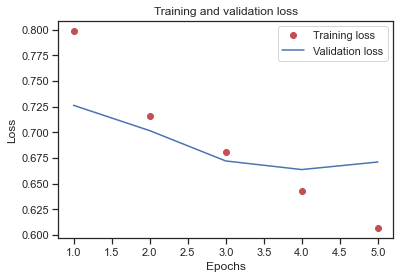

In [34]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6.4 Model Evaluation

In [35]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()

19576/19576 [==============================] - 11s 545us/step


0.7938862